In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# mostrar todas as colunas
pd.set_option('display.max_columns', None)

# importando o arquivo
df = pd.read_csv("/content/drive/MyDrive/FACULDADE/datasets/fetal_health/fetal_health.csv")


In [10]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [11]:
df.shape

(2126, 22)

In [12]:
#PRÉ-PROCESSAMENTO
# 2 Tratamento de valores ausentes
# ----------------------------
# Substitui valores ausentes: numéricos pela média, categóricos pela moda
def trata_faltantes(df):
    df = df.copy()
    colunas_numericas = df.select_dtypes(include='number').columns
    colunas_categoricas = df.select_dtypes(include='object').columns

    for col in colunas_numericas:
        df[col] = df[col].fillna(df[col].mean())
    for col in colunas_categoricas:
        moda_serie = df[col].mode()
        if not moda_serie.empty:
            df[col] = df[col].fillna(moda_serie.iloc[0])
    return df

df = trata_faltantes(df)
print("✅ Valores ausentes tratados.")


✅ Valores ausentes tratados.


In [13]:
# 3 Limpeza de valores inválidos
# ----------------------------
# Remove registros fora do intervalo esperado ou ilógicos
def limpar_valores_invalidos_fetal(df):
    df_original = df.copy()
    total_inicial = len(df)

    def filtrar(df, condicao, nome):
        antes = len(df)
        df_filtrado = df[condicao]
        print(f"{nome}: {antes - len(df_filtrado)} registros removidos")
        return df_filtrado

    df = filtrar(df, (df['baseline value'] >= 80) & (df['baseline value'] <= 200), "Baseline inválido")
    df = filtrar(df, df['accelerations'] >= 0, "Accelerations inválido")
    df = filtrar(df, df['fetal_movement'] >= 0, "Fetal movement inválido")
    df = filtrar(df, df['uterine_contractions'] >= 0, "Uterine contractions inválido")
    df = filtrar(df, (df['light_decelerations'] >= 0) &
                     (df['severe_decelerations'] >= 0) &
                     (df['prolongued_decelerations'] >= 0), "Decelerations inválidos")
    df = filtrar(df, df['abnormal_short_term_variability'] >= 0, "Short term variability inválida")
    df = filtrar(df, (df['mean_value_of_short_term_variability'] >= 0) &
                     (df['mean_value_of_long_term_variability'] >= 0), "Mean variability inválida")
    df = filtrar(df, df['histogram_min'] <= df['histogram_max'], "Histograma min > max")
    df = filtrar(df, df['histogram_width'] > 0, "Histogram width inválido")
    df = filtrar(df, df['fetal_health'].isin([1,2,3]), "Fetal health inválido")

    print(f"\nTotal registros removidos: {total_inicial - len(df)}. Total final: {len(df)}")
    return df

df = limpar_valores_invalidos_fetal(df)


Baseline inválido: 0 registros removidos
Accelerations inválido: 0 registros removidos
Fetal movement inválido: 0 registros removidos
Uterine contractions inválido: 0 registros removidos
Decelerations inválidos: 0 registros removidos
Short term variability inválida: 0 registros removidos
Mean variability inválida: 0 registros removidos
Histograma min > max: 0 registros removidos
Histogram width inválido: 0 registros removidos
Fetal health inválido: 0 registros removidos

Total registros removidos: 0. Total final: 2126


In [14]:
# 4 Remoção de duplicados
# ----------------------------
# Remove linhas exatamente iguais
def remove_duplicados_exatos(df):
    antes = len(df)
    df = df.drop_duplicates(keep='first')
    print(f"✅ Duplicados removidos: {antes - len(df)}. Total final: {len(df)}")
    return df

df = remove_duplicados_exatos(df)


✅ Duplicados removidos: 13. Total final: 2113


In [15]:
# 5 Normalização das colunas numéricas
# ----------------------------
# Normaliza todas as colunas numéricas exceto a coluna alvo
def normalizar_fetal(df, colunas_numericas=None, excluir_label=True):
    df = df.copy()
    if colunas_numericas is None:
        colunas_numericas = df.select_dtypes(include='number').columns.tolist()
    if excluir_label and 'fetal_health' in colunas_numericas:
        colunas_numericas = [c for c in colunas_numericas if c != 'fetal_health']
    X = df[colunas_numericas].values.astype(float)
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    sigma[sigma == 0] = 1
    X_norm = (X - mu)/sigma
    df[colunas_numericas] = X_norm
    return df, mu, sigma, colunas_numericas

df, mu, sigma, colunas_numericas = normalizar_fetal(df)


/tmp/ipython-input-3231315712.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="fetal_health", palette=colours)


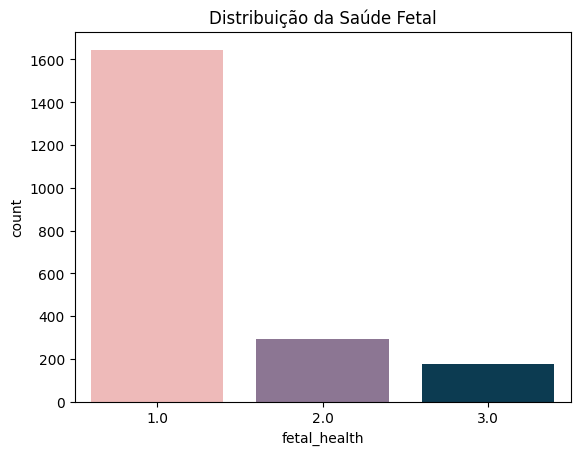

In [16]:
# 6 Visualização inicial
# ----------------------------
# Mostra distribuição da classe alvo
colours = ["#f7b2b0","#8f7198", "#003f5c"]
sns.countplot(data=df, x="fetal_health", palette=colours)
plt.title("Distribuição da Saúde Fetal")
plt.show()


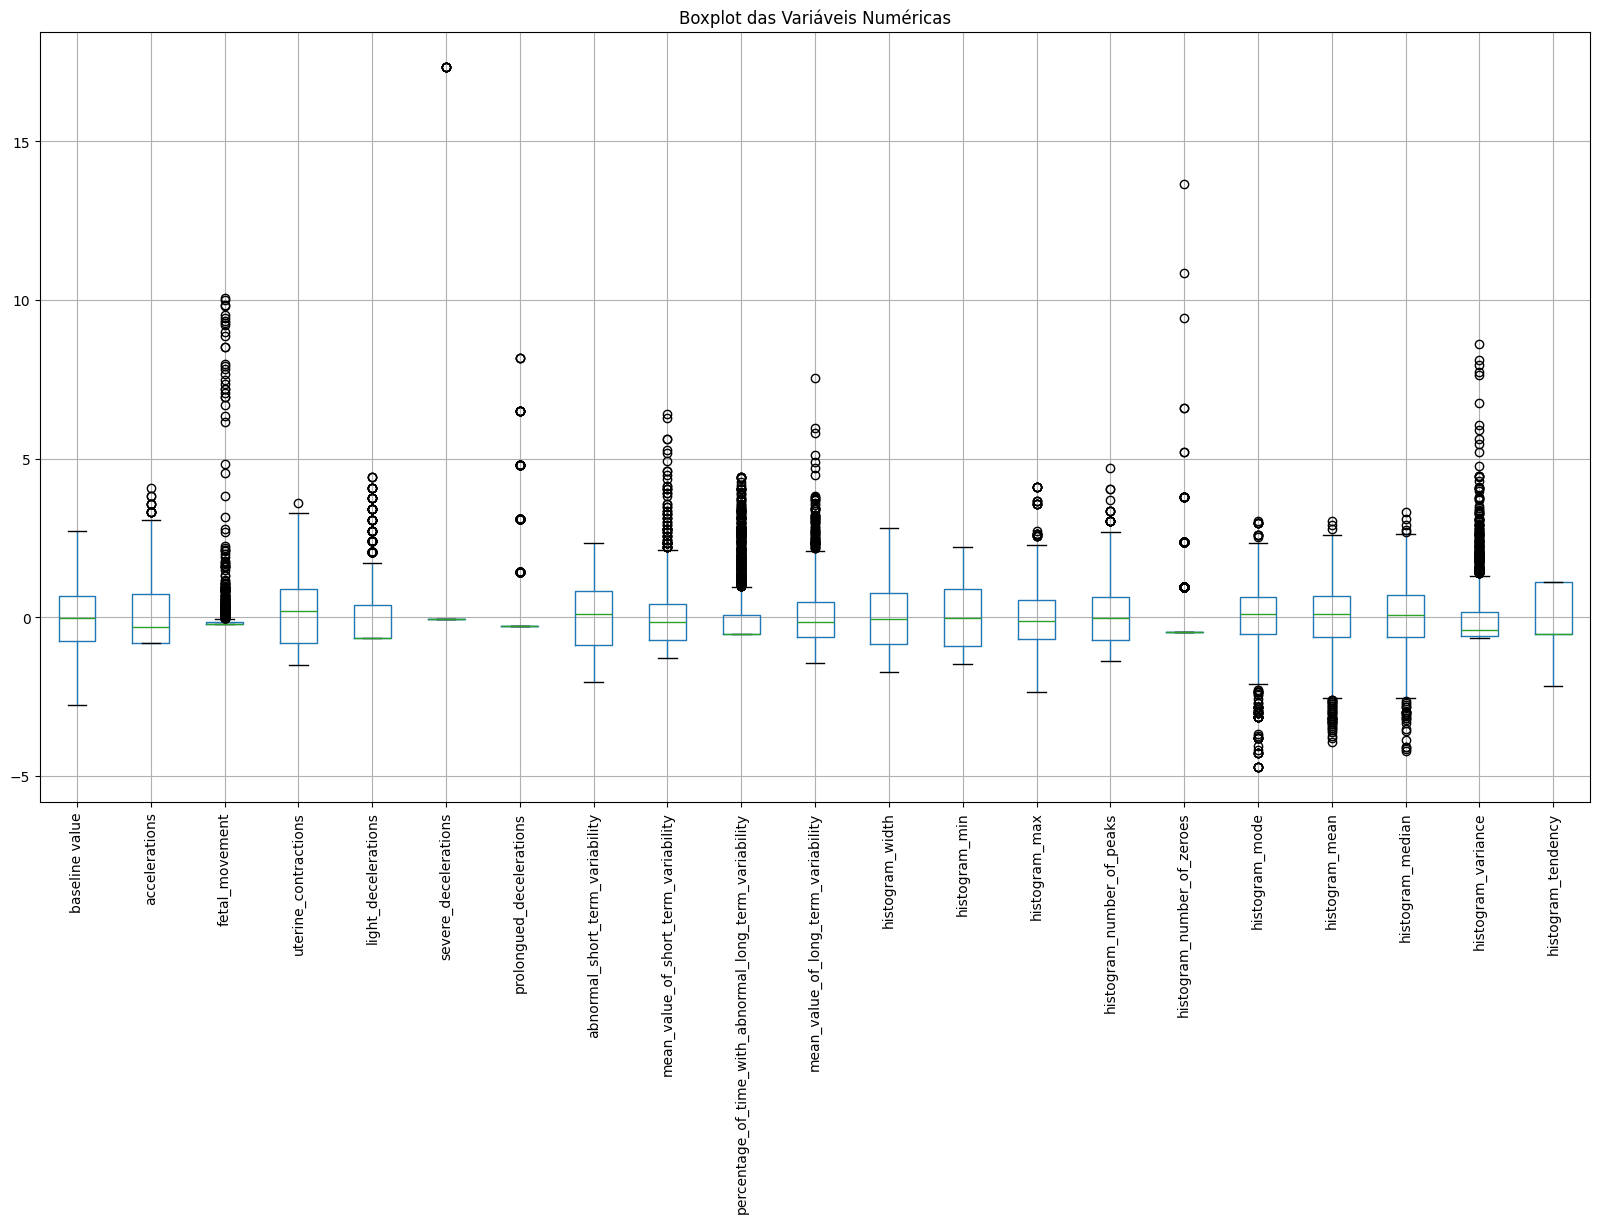

In [17]:
# 7 Boxplot das variáveis numéricas
# ----------------------------
# Mostra boxplot para detectar outliers visuais
df.boxplot(column=colunas_numericas, figsize=(20,10), rot=90)
plt.title("Boxplot das Variáveis Numéricas")
plt.show()


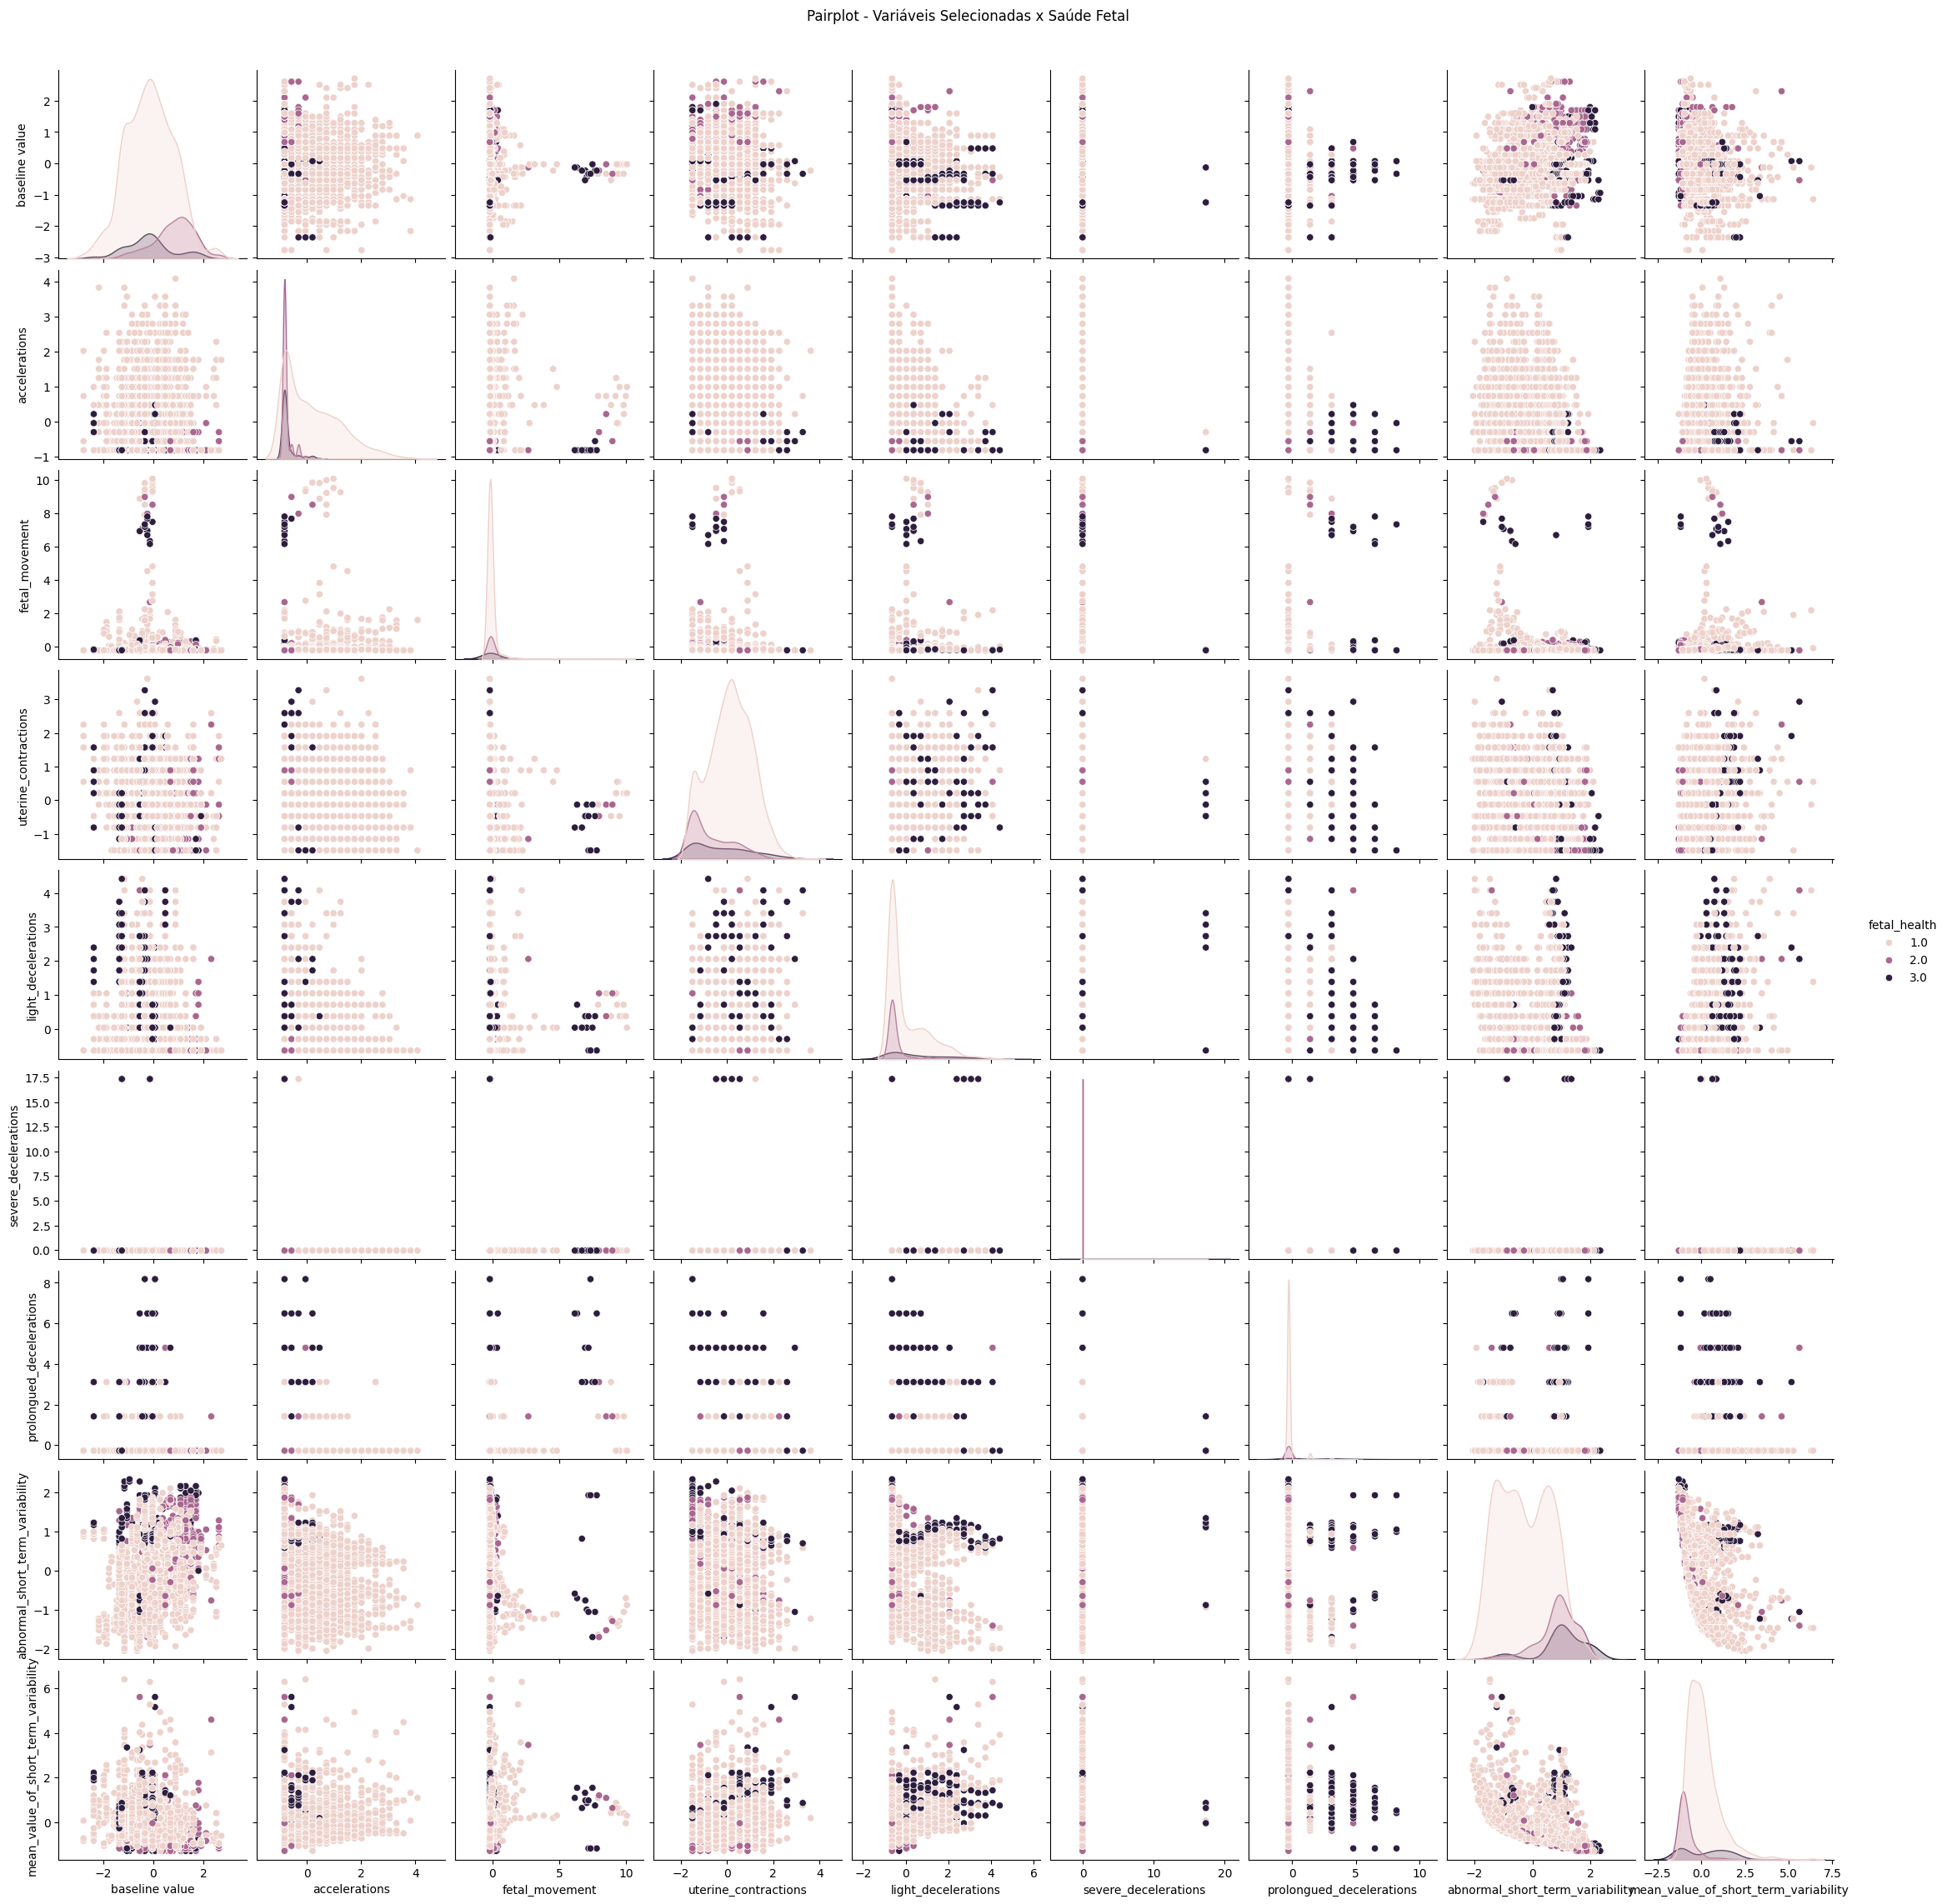

In [18]:
# 8 Pairplot com algumas variáveis
# ----------------------------
# Visualiza correlação entre features selecionadas e classe alvo
vars_pairplot = [
    'baseline value', 'accelerations', 'fetal_movement',
    'uterine_contractions', 'light_decelerations', 'severe_decelerations',
    'prolongued_decelerations', 'abnormal_short_term_variability',
    'mean_value_of_short_term_variability'
]
sns.pairplot(df, hue='fetal_health', vars=vars_pairplot, height=2.5, diag_kind="kde")
plt.suptitle("Pairplot - Variáveis Selecionadas x Saúde Fetal", y=1.02)
plt.show()


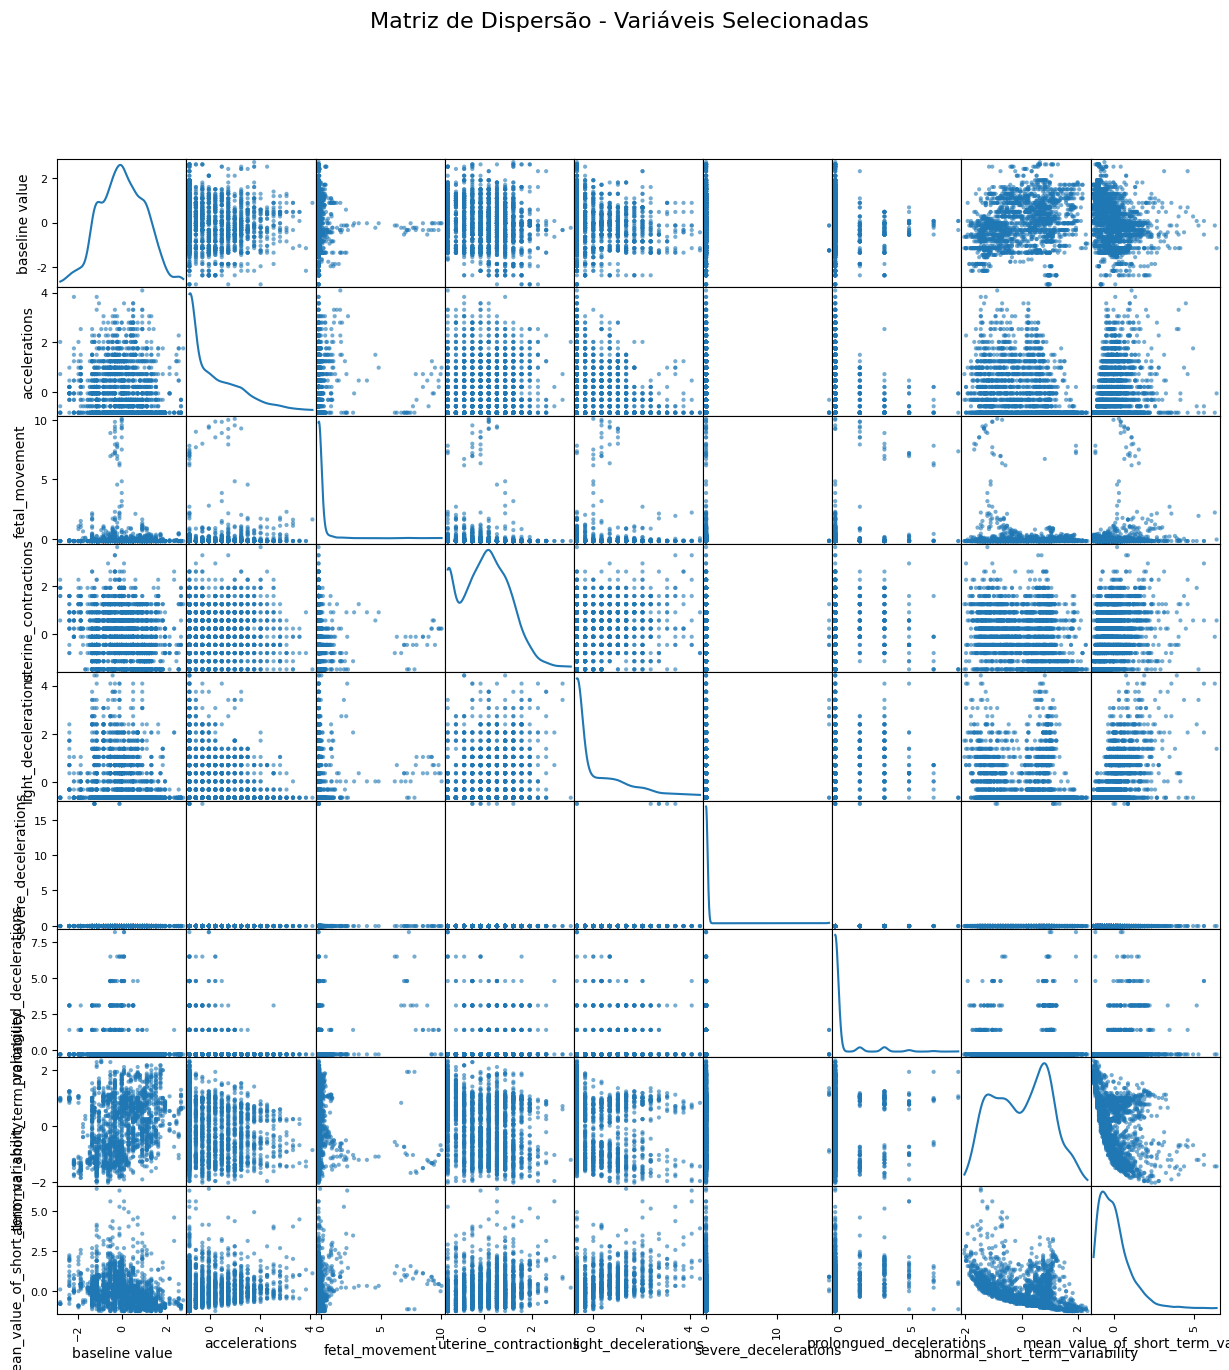

In [19]:
# 9 Scatter matrix
# ----------------------------
# Explora visualmente relações e densidades das variáveis
pd.plotting.scatter_matrix(df[vars_pairplot], figsize=(15,15), diagonal='kde', alpha=0.6)
plt.suptitle("Matriz de Dispersão - Variáveis Selecionadas", fontsize=16)
plt.show()



================ Random Forest ================
Acurácia: 0.9527
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       330
         2.0       0.93      0.72      0.82        58
         3.0       1.00      0.91      0.96        35

    accuracy                           0.95       423
   macro avg       0.96      0.88      0.91       423
weighted avg       0.95      0.95      0.95       423



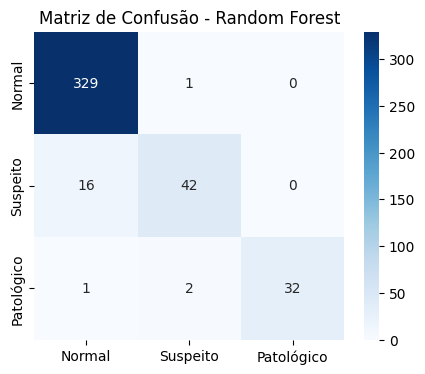


================ Logistic Regression ================


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acurácia: 0.8889
              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94       330
         2.0       0.64      0.55      0.59        58
         3.0       0.90      0.77      0.83        35

    accuracy                           0.89       423
   macro avg       0.82      0.76      0.79       423
weighted avg       0.88      0.89      0.88       423



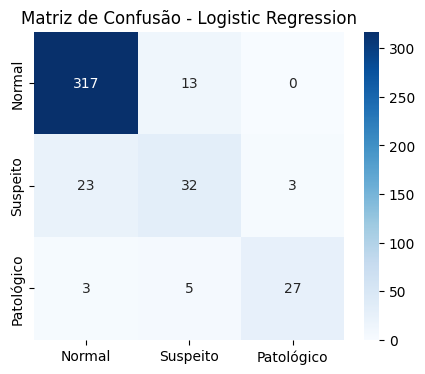


================ KNN ================
Acurácia: 0.8889
              precision    recall  f1-score   support

         1.0       0.91      0.98      0.94       330
         2.0       0.70      0.53      0.61        58
         3.0       0.92      0.66      0.77        35

    accuracy                           0.89       423
   macro avg       0.84      0.72      0.77       423
weighted avg       0.88      0.89      0.88       423



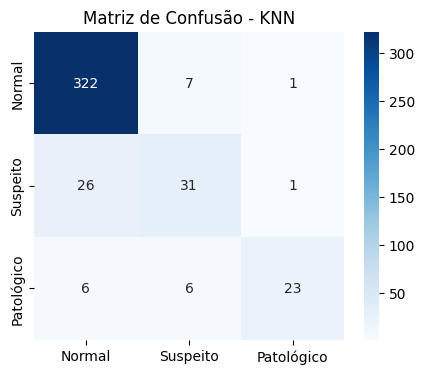

🏆 Comparativo de Acurácia:


,Modelo,Acurácia
0,Random Forest,0.952719
1,Logistic Regression,0.888889
2,KNN,0.888889


In [20]:
# TREINAMENTO
# 10 Comparativo de Classificadores
# ----------------------------
# Verifica qual algoritmo performa melhor (Random Forest, Logistic Regression, KNN)
X = df.drop("fetal_health", axis=1)
y = df["fetal_health"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, model in classifiers.items():
    print(f"\n================ {name} ================")
    pipeline = Pipeline([("scaler", StandardScaler()), ("clf", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Suspeito","Patológico"],
                yticklabels=["Normal","Suspeito","Patológico"])
    plt.title(f"Matriz de Confusão - {name}")
    plt.show()
    results[name] = acc

results_df = pd.DataFrame(list(results.items()), columns=["Modelo","Acurácia"]).sort_values(by="Acurácia", ascending=False)
print("🏆 Comparativo de Acurácia:")
display(results_df)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros encontrados: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       330
         2.0       0.93      0.72      0.82        58
         3.0       1.00      0.91      0.96        35

    accuracy                           0.95       423
   macro avg       0.96      0.88      0.91       423
weighted avg       0.95      0.95      0.95       423

Acurácia: 0.9527186761229315


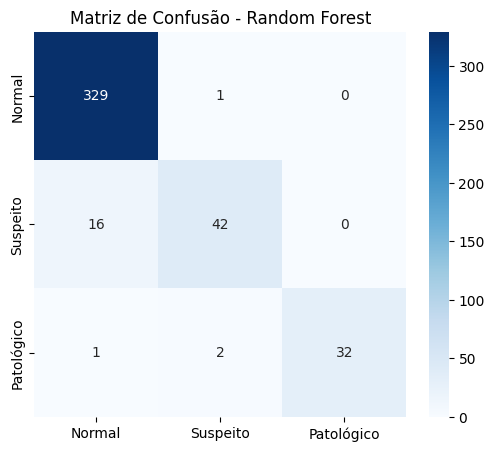

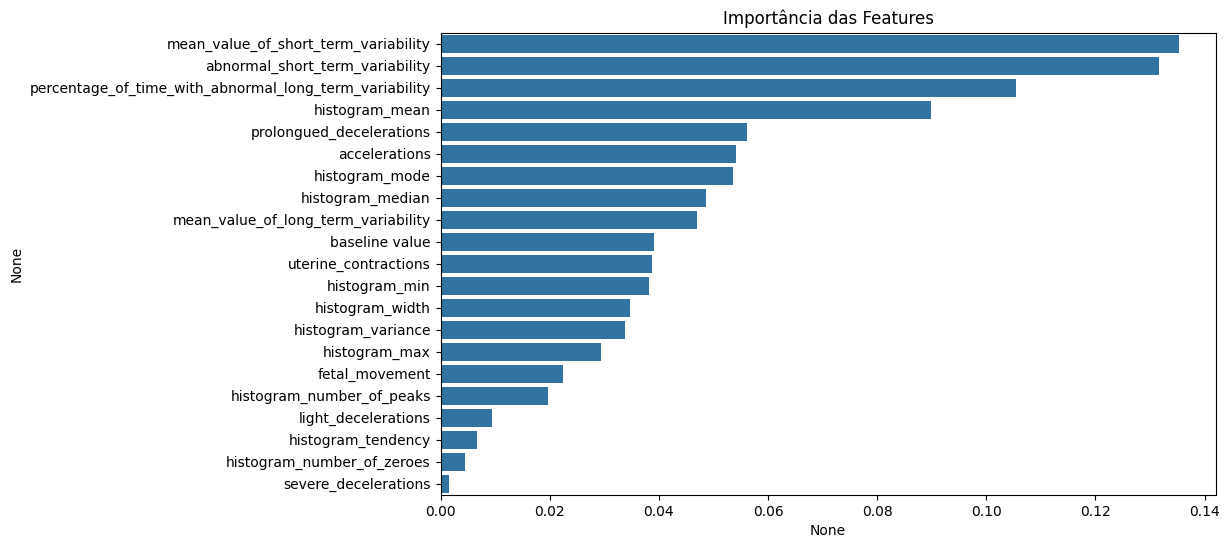

Features selecionadas: ['mean_value_of_short_term_variability', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mean', 'prolongued_decelerations', 'accelerations', 'histogram_mode', 'histogram_median', 'mean_value_of_long_term_variability', 'baseline value', 'uterine_contractions', 'histogram_min', 'histogram_width', 'histogram_variance', 'histogram_max', 'fetal_movement', 'histogram_number_of_peaks']


In [21]:
# 11 GridSearch Random Forest e importância das features
# ----------------------------
# Treina Random Forest, encontra melhores parâmetros e avalia importância das features
pipeline = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))])
param_grid = {"clf__n_estimators":[100,200], "clf__max_depth":[None,10,20], "clf__min_samples_split":[2,5]}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Melhores parâmetros encontrados:", grid.best_params_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Suspeito","Patológico"],
            yticklabels=["Normal","Suspeito","Patológico"])
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# Importância das features
best_model = grid.best_estimator_.named_steps['clf']
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Importância das Features")
plt.show()

# Seleção de features acima do limiar
threshold = 0.01
selected_features = feature_importances[feature_importances>threshold].index.tolist()
print("Features selecionadas:", selected_features)


Features usadas para treinar o modelo:
['mean_value_of_short_term_variability', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mean', 'prolongued_decelerations', 'accelerations', 'histogram_mode', 'histogram_median', 'mean_value_of_long_term_variability', 'baseline value', 'uterine_contractions', 'histogram_min', 'histogram_width', 'histogram_variance', 'histogram_max', 'fetal_movement', 'histogram_number_of_peaks']
Total de features utilizadas: 17
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros (features selecionadas): {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}

Relatório de Classificação:
              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       330
         2.0       0.91      0.72      0.81        58
         3.0       0.97      0.91      0.94        35

    accuracy                           0.95       423
   

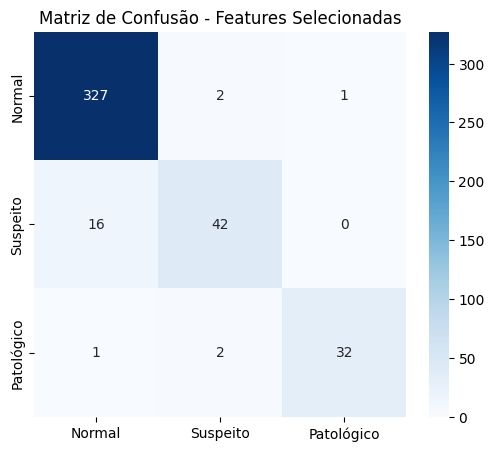

In [25]:
# 12 Retreino com features selecionadas
# ----------------------------
# Mostra quais features serão usadas e quantas são
print("Features usadas para treinar o modelo:")
print(selected_features)
print(f"Total de features utilizadas: {len(selected_features)}")  # <-- Aqui mostramos o total

# Re-treina Random Forest apenas com as features mais importantes
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

pipeline_sel = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

grid_sel = GridSearchCV(
    pipeline_sel,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid_sel.fit(X_train_sel, y_train)

print("Melhores parâmetros (features selecionadas):", grid_sel.best_params_)

y_pred_sel = grid_sel.predict(X_test_sel)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_sel))
print("Acurácia (features selecionadas):", accuracy_score(y_test, y_pred_sel))

cm_sel = confusion_matrix(y_test, y_pred_sel)
plt.figure(figsize=(6,5))
sns.heatmap(cm_sel, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Suspeito","Patológico"],
            yticklabels=["Normal","Suspeito","Patológico"])
plt.title("Matriz de Confusão - Features Selecionadas")
plt.show()
